In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statistics
from datetime import datetime
from pandas import Series
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import seaborn as sns
import os
import statistics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf          
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product      

from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing, Holt

from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import statsmodels.api as sm

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [4]:
from math import sqrt

def rmse(y_true, y_pred):
    squared_error = 0
    for i in range(len(y_true)):
        squared_error = squared_error + (y_true[i] - y_pred[i]) ** 2
    root_mean_squared_error = sqrt(squared_error / len(y_true))
    return root_mean_squared_error

In [5]:
def moving_avg(rounds):
    y_hat['avg'] = 0
    for i in range(len(Valid)):
        y_pred = 0
        for j in range(rounds):
            y_pred = y_pred + Train.footfall[len(Train) - (j + 1) * len(Valid) + i]
        y_hat['avg'][i] = y_pred / rounds

In [6]:
def test_stationary(timeseries):
    #Determine rolling statistics
    rolmean = pd.Series(timeseries).rolling(window = 28).mean()
    rolstd = pd.Series(timeseries).rolling(window = 28).std()
    
    #Plot rolling Statistics
    orig = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block = False)
    
    #Perform Dickey Fuller test
    print("Results of Dickey Fuller test: ")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lag Used', 'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

In [7]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

### Exclude Locations with Too Much Missing Data:

In [8]:
ff = pd.read_csv('stackfootfall.csv')
ff.timestamp = pd.to_datetime(ff.timestamp, format = '%Y-%m-%d %H:%M:%S') 

In [9]:
ff = ff.loc[(ff.timestamp >= '2018-01') & (ff.timestamp <= '2019-08-18 23:00')]

In [10]:
pred_accuracy = pd.DataFrame(columns = ('location', 'Naive', 'Moving_Average', 'Expoential_Smoothing', 
                                        'SARIMA', 'LSTM'))

dmtest = pd.DataFrame(columns = ('location', 'nm', 'p_nm', 'ne', 'p_ne', 'ns', 'p_ns', 
                                 'nl', 'p_nl', 'me', 'p_me', 'ms', 'p_ms', 'ml', 'p_ml', 
                                 'es', 'p_es', 'el', 'p_el', 'sl', 'p_sl'))

In [11]:
ff

,Unnamed: 0,timestamp,location,device,footfall,year,month,day,hour,day_of_week
0,0,2018-01-05 00:00:00,0.0,1240.0,NaN,2018,1,5,0,5
1,1,2018-01-05 01:00:00,0.0,1240.0,NaN,2018,1,5,1,5
2,2,2018-01-05 02:00:00,0.0,1240.0,NaN,2018,1,5,2,5
3,3,2018-01-05 03:00:00,0.0,1240.0,NaN,2018,1,5,3,5
4,4,2018-01-05 04:00:00,0.0,1240.0,NaN,2018,1,5,4,5
...,...,...,...,...,...,...,...,...,...,...
8896171,260179,2019-08-18 19:00:00,1228.0,1074.0,310.0,2019,8,18,19,7
8896172,260180,2019-08-18 20:00:00,1228.0,1074.0,137.0,2019,8,18,20,7
8896173,260181,2019-08-18 21:00:00,1228.0,1074.0,120.0,2019,8,18,21,7
8896174,260182,2019-08-18 22:00:00,1228.0,1074.0,46.0,2019,8,18,22,7


In [12]:
loc = 639

ff_loc = ff.loc[ff.location == loc][['timestamp','footfall','year','month','day','hour','day_of_week']]    
ff_loc.index = ff_loc.timestamp
ff_loc = ff_loc.resample('H').mean()

ff_loc['footfall'].replace(0, np.nan, inplace = True)
ff_loc['footfall'] = ff_loc['footfall'].interpolate(method='linear')
ff_loc = ff_loc.reset_index(level = ['timestamp'])
ff_loc.timestamp = pd.to_datetime(ff_loc.timestamp, format = '%Y-%m-%d %H:%M:%S')

temp = ff_loc[['timestamp', 'footfall']]
temp.index = temp.timestamp
temp['year'] = temp.timestamp.dt.year
temp['month'] = temp.timestamp.dt.month
temp['day'] = temp.timestamp.dt.day
temp['hour'] = temp.timestamp.dt.hour
temp['day_of_week'] = temp.timestamp.dt.dayofweek + 1

Train = temp.loc[(temp.timestamp >= '2018-01-01 00:00') & (temp.timestamp <= '2019-07-28 23:00')]
Valid = temp.loc[(temp.timestamp >= '2019-07-29 00:00') & (temp.timestamp <= '2019-08-18 23:00')]

if len(Valid) > 0:
    train = Train.resample('D').mean()
    valid = Valid.resample('D').mean() 

    train['footfall'] = train['footfall'].interpolate(method='linear')
    valid['footfall'] = valid['footfall'].interpolate(method='linear')

    # Monday to Thursday Ratio
    mtt = Train.loc[(Train.day_of_week >= 1) & (Train.day_of_week <= 4)].groupby('hour')['footfall'].mean().to_frame()
    mtt['ratio'] = mtt['footfall']/mtt['footfall'].sum()
    mtt = mtt.reset_index(level = ['hour'])

    # Friday Ratio
    fri = Train.loc[(Train.day_of_week >= 5) & (Train.day_of_week <= 5)].groupby('hour')['footfall'].mean().to_frame()
    fri['ratio'] = fri['footfall']/fri['footfall'].sum()
    fri = fri.reset_index(level = ['hour'])

    # Sat Ratio
    sat = Train.loc[(Train.day_of_week >= 6) & (Train.day_of_week <= 6)].groupby('hour')['footfall'].mean().to_frame()
    sat['ratio'] = sat['footfall']/sat['footfall'].sum()
    sat = sat.reset_index(level = ['hour'])

    # Sun Ratio
    sun = Train.loc[(Train.day_of_week >= 7) & (Train.day_of_week <= 7)].groupby('hour')['footfall'].mean().to_frame()
    sun['ratio'] = sun['footfall']/sun['footfall'].sum()
    sun = sun.reset_index(level = ['hour'])

    ratio1 = mtt[['hour','ratio']]
    ratio1['day_of_week'] = 1
    ratio2 = mtt[['hour','ratio']]
    ratio2['day_of_week'] = 2
    ratio3 = mtt[['hour','ratio']]
    ratio3['day_of_week'] = 3
    ratio4 = mtt[['hour','ratio']]
    ratio4['day_of_week'] = 4
    ratio5 = fri[['hour','ratio']] 
    ratio5['day_of_week'] = 5
    ratio6 = sat[['hour','ratio']]
    ratio6['day_of_week'] = 6
    ratio7 = sun[['hour','ratio']]
    ratio7['day_of_week'] = 7

    ratio_week = ratio1.append(ratio2).append(ratio3).append(ratio4).append(ratio5).append(ratio6).append(ratio7)

    merge = pd.merge(Valid, ratio_week, on = ('hour','day_of_week'), how = 'left')

    # Naive Approach
    dd = np.asarray(Train['footfall'])
    y_hat = Valid.copy()
    y_hat['naive']= dd[len(dd)- 1]
    for i in range(len(Valid)): 
        y_hat['naive'][i]= dd[len(dd) - len(Valid) + i]
    naive_rmse = rmse(Valid.footfall, y_hat.naive)


    # Moving Average Approach    
    moving_avg(4)
    avg4_rmse = rmse(Valid.footfall, y_hat.avg)
    moving_avg(6)
    avg6_rmse = rmse(Valid.footfall, y_hat.avg)    
    moving_avg(8)
    avg8_rmse = rmse(Valid.footfall, y_hat.avg)
    moving_avg(10)
    avg10_rmse = rmse(Valid.footfall, y_hat.avg)

    avg_rmse = min(avg4_rmse, avg6_rmse, avg8_rmse, avg10_rmse) 
    ma_temp = [avg4_rmse, avg6_rmse, avg8_rmse, avg10_rmse] 
    windows = (ma_temp.index(avg_rmse) + 2) * 2   
    moving_avg(windows)


    # Exponential Smoothing
    y_hat2 = valid.copy()
    fit1 = ExponentialSmoothing(np.asarray(train.footfall), seasonal_periods = 7, trend = 'add', seasonal= 'add').fit()
    y_hat2['Holt_Winter'] = fit1.forecast(len(valid))

    pred_d = y_hat2.Holt_Winter.to_frame()
    pred_d = pred_d.reset_index(level = ['timestamp'])
    pred_d['month'] = pred_d.timestamp.dt.month
    pred_d['day'] = pred_d.timestamp.dt.day
    temp1 = pd.merge(merge, pred_d, on = ('month','day'), how = 'left')
    temp1['prediction'] = temp1['ratio'] * temp1['Holt_Winter'] * 24
    temp1.index = temp1.timestamp_x
    y_hat['Holt_Winter'] = temp1['prediction']
    holt_winter_rmse = rmse(Valid.footfall, y_hat['Holt_Winter'])

    # SARIMA
    arima_model = auto_arima(train.footfall, X = None, start_p = 0, d = 1, 
                     start_q = 0, max_p = 5, max_d=2, max_q=5, start_P = 0, 
                     D = 1, start_Q = 0, max_P = 5, max_D = 5, max_Q = 5, 
                     m = 7, seasonal = True, stepwise = True, n_jobs = 1, 
                     error_action = 'warn', trace = True, random = False, 
                     random_state = 20, n_fits = 50 )

    y_hat2['SARIMA'] = arima_model.predict(n_periods = len(valid))

    pred_d = pd.DataFrame(y_hat2['SARIMA'], index = valid.index)
    pred_d = pred_d.reset_index(level = ['timestamp'])
    pred_d['month'] = pred_d.timestamp.dt.month
    pred_d['day'] = pred_d.timestamp.dt.day
    temp2 = pd.merge(merge, pred_d, on = ('month','day'), how = 'left')
    temp2['prediction'] = temp2['ratio'] * temp2['SARIMA'] * 24
    temp2.index = temp2.timestamp_x
    y_hat['SARIMA'] = temp2['prediction']
    sarima_rmse = rmse(Valid.footfall, y_hat['SARIMA'])

    # LSTM 
    train = temp.loc[(temp.timestamp >= '2018-01-01 00:00') & (temp.timestamp <= '2019-07-28 23:00')][[
        'footfall','month','day','hour','day_of_week']]
    test = temp.loc[(temp.timestamp >= '2019-07-28 14:00') & (temp.timestamp <= '2019-08-18 23:00')][[
        'footfall','month','day','hour','day_of_week']]  

    ff_transformer = RobustScaler()
    ff_transformer = ff_transformer.fit(train[['footfall']])

    train['footfall'] = ff_transformer.transform(train[['footfall']])
    test['footfall'] = ff_transformer.transform(test[['footfall']])

    time_steps = 10
    X_train, y_train = create_dataset(train, train.footfall, time_steps)
    X_test, y_test = create_dataset(test, test.footfall, time_steps)

    model = keras.Sequential()
    model.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
          units=128, 
          input_shape=(X_train.shape[1], X_train.shape[2])
        )
      )
    )
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')    

    history = model.fit(
    X_train, y_train, 
    epochs = 30, 
    batch_size = 32, 
    validation_split = 0.1,
    shuffle = False
    )

    y_pred = model.predict(X_test)

    y_train_inv = ff_transformer.inverse_transform(y_train.reshape(1, -1))
    y_test_inv = ff_transformer.inverse_transform(y_test.reshape(1, -1))
    y_pred_inv = ff_transformer.inverse_transform(y_pred)

    y_hat['LSTM'] =  y_pred_inv.flatten()
    lstm_rmse = rmse(y_test_inv.flatten(), y_pred_inv.flatten())

    # save prediction
    pred_loc = y_hat[['naive','avg','Holt_Winter','SARIMA','LSTM']]


    pred_accuracy = pred_accuracy.append({'location': loc, 'Naive': naive_rmse, 'Moving_Average': avg_rmse, 
                                        'Expoential_Smoothing': holt_winter_rmse, 'SARIMA': sarima_rmse, 
                                        'LSTM': lstm_rmse}, ignore_index=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5961.419, Time=0.38 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5774.114, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=5931.996, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=5698.979, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=5664.181, Time=0.71 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=5631.639, Time=1.30 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=5626.238, Time=1.74 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=3.06 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=5656.561, Time=1.23 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=5612.971, Time=1.84 sec
 ARIMA(2,1,0)(4,1,0)[7]             : AIC=5618.955, Time=1.09 sec
 ARIMA(2,1,0)(5,1,1)[7]             : AIC=inf, Time=11.09 sec
 ARIMA(2,1,0)(4,1,1)[7]             : AIC=inf, Time=6

In [13]:
pred_accuracy = pred_accuracy.drop_duplicates(subset='location')
pred_accuracy

,location,Naive,Moving_Average,Expoential_Smoothing,SARIMA,LSTM
0,639.0,68.578061,53.407148,54.006851,53.202069,49.29443


Text(0.5, 1.0, 'Forecast')

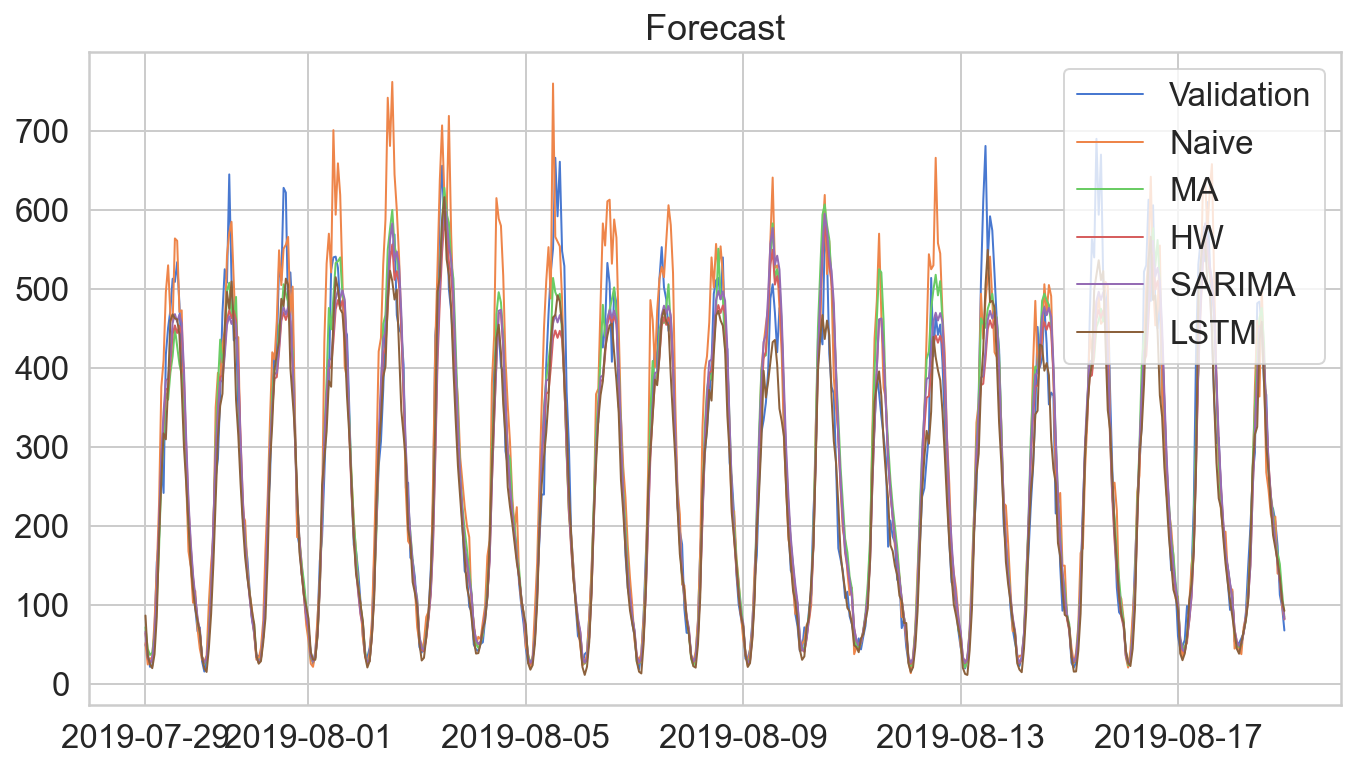

In [16]:
plt.figure(figsize = (10,6))

plt.plot(Valid.index, Valid['footfall'], label = 'Validation', linewidth = 1)
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive', linewidth = 1)
plt.plot(y_hat.index, y_hat['avg'], label = 'MA', linewidth = 1)
plt.plot(y_hat.index, y_hat['Holt_Winter'], label = 'HW', linewidth = 1)
plt.plot(y_hat.index, y_hat['SARIMA'], label = 'SARIMA', linewidth = 1)
plt.plot(y_hat.index, y_hat['LSTM'], label = 'LSTM', linewidth = 1)

plt.legend(loc = 'best')
plt.title('Forecast')

Text(0.5, 1.0, 'Forecast')

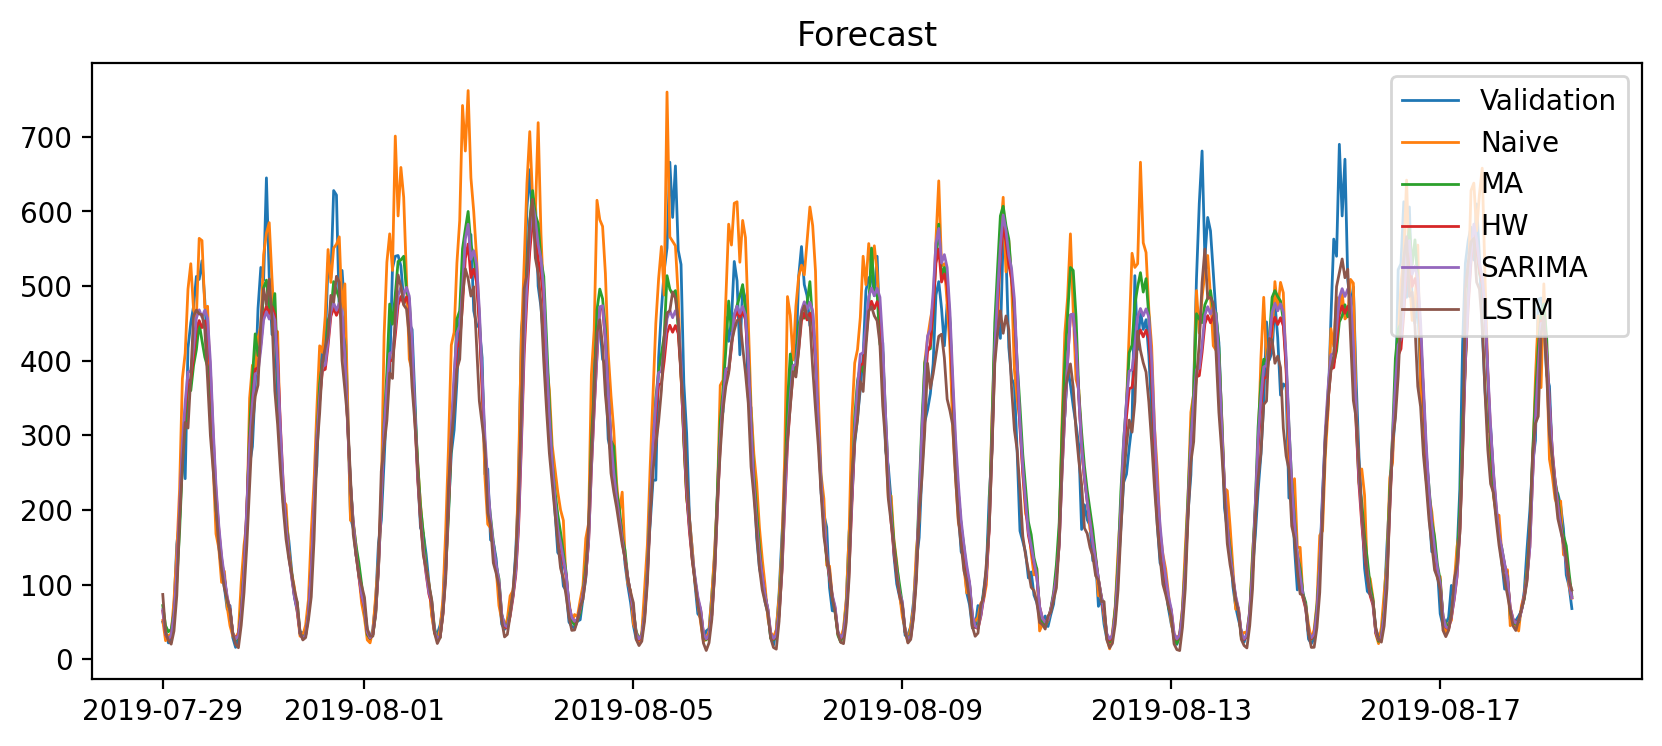

In [20]:
plt.figure(figsize = (10,4))
plt.style.use('default')
plt.plot(Valid.index, Valid['footfall'], label = 'Validation', linewidth = 1)
plt.plot(y_hat.index, y_hat['naive'], label = 'Naive', linewidth = 1)
plt.plot(y_hat.index, y_hat['avg'], label = 'MA', linewidth = 1)
plt.plot(y_hat.index, y_hat['Holt_Winter'], label = 'HW', linewidth = 1)
plt.plot(y_hat.index, y_hat['SARIMA'], label = 'SARIMA', linewidth = 1)
plt.plot(y_hat.index, y_hat['LSTM'], label = 'LSTM', linewidth = 1)

plt.legend(loc = 'best')
plt.title('Forecast')